<a href="https://colab.research.google.com/github/laiyti/-/blob/main/The_Uber_Fares_Predictive_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **The Uber Fares Predictive Analysis** ##

Uber, a name synonymous with ridesharing, holds a staggering 76% market share in the United States. Despite widespread car ownership, many, including us, opt for alternatives like Uber and Lyft. This reliance on ride services sparks curiosity about the ever-changing Uber fares and the underlying factors influencing these fluctuations. While distance remains a key determinant, our investigation seeks to unveil the additional factors contributing to the dynamic and sometimes unpredictable pricing throughout the day. Join us as we explore the intricacies of Uber fare dynamics in this report.

Data: We utilizes the data captured in November and December of 2018.

Data is [here](https://www.kaggle.com/datasets/ravi72munde/uber-lyft-cab-prices/data)

![Uber](https://www.uber-assets.com/image/upload/f_auto,q_auto:eco,c_fill,w_1116,h_744/v1567754728/assets/5a/2235f5-b76b-452e-8d60-089daaec70b7/original/Vehicle-solutions.png)

 # Part 1: Data Cleaning #

### 1-1. Import packages

In [ ]:
#Import packages
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

### 1-2. Import datasets and data cleaning

In [ ]:
#Import datasets
#df1: cab_rides data
#df2: weather data
df1 = pd.read_csv('cab_rides.csv')
df1.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [ ]:
df2 = pd.read_csv('weather.csv')
df2.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [ ]:
#Check if null value exists
print(df1.isnull().sum())
print(df2.isnull().sum())

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64
temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64


In [ ]:
#Create dummy variables for rain
df2['rain_dummy'] = df2['rain'].apply(lambda x: 1 if x > 0 else 0)

# Drop the original 'rain' column if you don't need it anymore
df2 = df2.drop(columns=['rain'])

#Drop null values in both datasets
df1 = df1.dropna(axis=0)
df2 = df2.dropna(axis=0)

#Check if null values cleaned
print(df1.isnull().sum())
print(df2.isnull().sum())

distance            0
cab_type            0
time_stamp          0
destination         0
source              0
price               0
surge_multiplier    0
id                  0
product_id          0
name                0
dtype: int64
temp          0
location      0
clouds        0
pressure      0
time_stamp    0
humidity      0
wind          0
rain_dummy    0
dtype: int64


### 1-3. Merge two datasets

In [ ]:
#Split data to uber can lyft (Only 'uber_df' will be used)
uber_df = df1[df1['cab_type'] == 'Uber']
lyft_df = df1[df1['cab_type'] == 'Lyft']

In [ ]:
#Transform timestamp to date_time
uber_df = uber_df.copy()
uber_df['date_time'] = pd.to_datetime(uber_df['time_stamp'], unit='ms')
uber_df.sort_values(by='date_time', ignore_index=True, inplace=True)
uber_df = uber_df.drop(['time_stamp', 'id'], axis=1)
uber_df.head()

,distance,cab_type,destination,source,price,surge_multiplier,product_id,name,date_time
0,1.30,Uber,Theatre District,South Station,18.5,1.0,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-11-26 03:40:46.319
1,2.71,Uber,Fenway,Theatre District,32.0,1.0,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-26 03:40:46.320
2,2.71,Uber,Fenway,Theatre District,19.5,1.0,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-26 03:40:46.320
3,2.19,Uber,North End,Beacon Hill,13.0,1.0,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-26 03:40:46.358
4,2.19,Uber,North End,Beacon Hill,8.0,1.0,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-26 03:40:46.358


In [ ]:
#Transform timestamp to date_time
df2['date_time'] = pd.to_datetime(df2['time_stamp'], unit='s')
df2.sort_values(by='date_time', ignore_index=True)
df2 = df2.drop('time_stamp', axis=1)
df2.head()

,temp,location,clouds,pressure,humidity,wind,rain_dummy,date_time
0,42.42,Back Bay,1.0,1012.14,0.77,11.25,1,2018-12-16 23:45:01
1,42.43,Beacon Hill,1.0,1012.15,0.76,11.32,1,2018-12-16 23:45:01
2,42.50,Boston University,1.0,1012.15,0.76,11.07,1,2018-12-16 23:45:01
3,42.11,Fenway,1.0,1012.13,0.77,11.09,1,2018-12-16 23:45:01
4,43.13,Financial District,1.0,1012.14,0.75,11.49,1,2018-12-16 23:45:01


In [ ]:
uber_df.info()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330568 entries, 0 to 330567
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   distance          330568 non-null  float64       
 1   cab_type          330568 non-null  object        
 2   destination       330568 non-null  object        
 3   source            330568 non-null  object        
 4   price             330568 non-null  float64       
 5   surge_multiplier  330568 non-null  float64       
 6   product_id        330568 non-null  object        
 7   name              330568 non-null  object        
 8   date_time         330568 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 22.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   temp  

In [ ]:
#Merge two datasets on 'date_time'
uber_df_sorted = uber_df.sort_values('date_time')
df2_sorted = df2.sort_values('date_time')
uber_df_temp = pd.merge_asof(uber_df_sorted, df2_sorted, on='date_time', direction='nearest')

#Filter datas that ride location match weather location
uber_df_final = uber_df_temp[(uber_df_temp['source'] == uber_df_temp['location'])]
uber_df_final = uber_df_final.drop('location', axis=1)
uber_df_final.reset_index()
uber_df_final.head()

,distance,cab_type,destination,source,price,surge_multiplier,product_id,name,date_time,temp,clouds,pressure,humidity,wind,rain_dummy
38,1.08,Uber,North End,North Station,7.0,1.0,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-11-26 04:40:55.518,40.76,0.88,1013.96,0.93,2.72,0
39,1.08,Uber,North End,North Station,10.5,1.0,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-26 04:40:55.518,40.76,0.88,1013.96,0.93,2.72,0
40,1.08,Uber,North End,North Station,7.0,1.0,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-26 04:40:55.518,40.76,0.88,1013.96,0.93,2.72,0
75,0.56,Uber,Haymarket Square,North Station,9.5,1.0,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-11-26 04:40:57.256,40.76,0.88,1013.96,0.93,2.72,0
77,0.56,Uber,Haymarket Square,North Station,14.0,1.0,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-26 04:40:57.256,40.76,0.88,1013.96,0.93,2.72,0


In [ ]:
#Convert the date_time to EST time zone
uber_df_final['date_time'] = pd.to_datetime(uber_df_final['date_time'])  # Convert to pandas Timestamp
# Set the time zone to UTC
utc_zone = pytz.timezone('UTC')
uber_df_final['date_time_utc'] = uber_df_final['date_time'].dt.tz_localize(utc_zone)

# Convert to Eastern Standard Time (EST)
est_zone = pytz.timezone('US/Eastern')
uber_df_final['date_time_est'] = uber_df_final['date_time_utc'].dt.tz_convert(est_zone)

print(uber_df_final[['date_time', 'date_time_est']])

                     date_time                    date_time_est
38     2018-11-26 04:40:55.518 2018-11-25 23:40:55.518000-05:00
39     2018-11-26 04:40:55.518 2018-11-25 23:40:55.518000-05:00
40     2018-11-26 04:40:55.518 2018-11-25 23:40:55.518000-05:00
75     2018-11-26 04:40:57.256 2018-11-25 23:40:57.256000-05:00
77     2018-11-26 04:40:57.256 2018-11-25 23:40:57.256000-05:00
...                        ...                              ...
330491 2018-12-18 19:15:04.817 2018-12-18 14:15:04.817000-05:00
330492 2018-12-18 19:15:04.817 2018-12-18 14:15:04.817000-05:00
330494 2018-12-18 19:15:04.817 2018-12-18 14:15:04.817000-05:00
330506 2018-12-18 19:15:06.449 2018-12-18 14:15:06.449000-05:00
330567 2018-12-18 19:15:10.943 2018-12-18 14:15:10.943000-05:00

[27434 rows x 2 columns]


In [ ]:
# Create a copy of the DataFrame
uber_df_final_copy = uber_df_final.copy()

# Update the 'weekday', 'hour', and 'weekday_hour' columns
uber_df_final_copy['weekday'] = uber_df_final_copy['date_time_est'].dt.weekday
uber_df_final_copy['hour'] = uber_df_final_copy['date_time_est'].dt.hour

#Remove unnecessary columns
uber_df_final_copy = uber_df_final_copy.drop(['cab_type', 'product_id', 'surge_multiplier', \
                                              'date_time', 'date_time_utc'], axis=1)

uber_df_final_copy.head()

,distance,destination,source,price,name,temp,clouds,pressure,humidity,wind,rain_dummy,date_time_est,weekday,hour
38,1.08,North End,North Station,7.0,WAV,40.76,0.88,1013.96,0.93,2.72,0,2018-11-25 23:40:55.518000-05:00,6,23
39,1.08,North End,North Station,10.5,UberXL,40.76,0.88,1013.96,0.93,2.72,0,2018-11-25 23:40:55.518000-05:00,6,23
40,1.08,North End,North Station,7.0,UberX,40.76,0.88,1013.96,0.93,2.72,0,2018-11-25 23:40:55.518000-05:00,6,23
75,0.56,Haymarket Square,North Station,9.5,WAV,40.76,0.88,1013.96,0.93,2.72,0,2018-11-25 23:40:57.256000-05:00,6,23
77,0.56,Haymarket Square,North Station,14.0,UberXL,40.76,0.88,1013.96,0.93,2.72,0,2018-11-25 23:40:57.256000-05:00,6,23


In [ ]:
uber_df_final_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27434 entries, 38 to 330567
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype                     
---  ------         --------------  -----                     
 0   distance       27434 non-null  float64                   
 1   destination    27434 non-null  object                    
 2   source         27434 non-null  object                    
 3   price          27434 non-null  float64                   
 4   name           27434 non-null  object                    
 5   temp           27434 non-null  float64                   
 6   clouds         27434 non-null  float64                   
 7   pressure       27434 non-null  float64                   
 8   humidity       27434 non-null  float64                   
 9   wind           27434 non-null  float64                   
 10  rain_dummy     27434 non-null  int64                     
 11  date_time_est  27434 non-null  datetime64[ns, US/Eastern]
 12  we

 # Part 2: Exploratory Data Analysis #

### 2-1. Analyze the price from each weekday and each hour

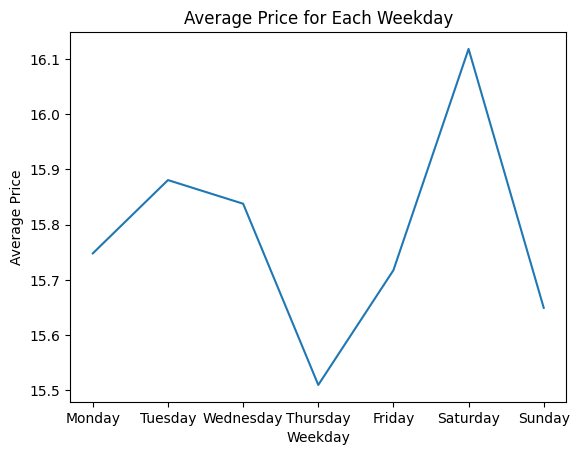

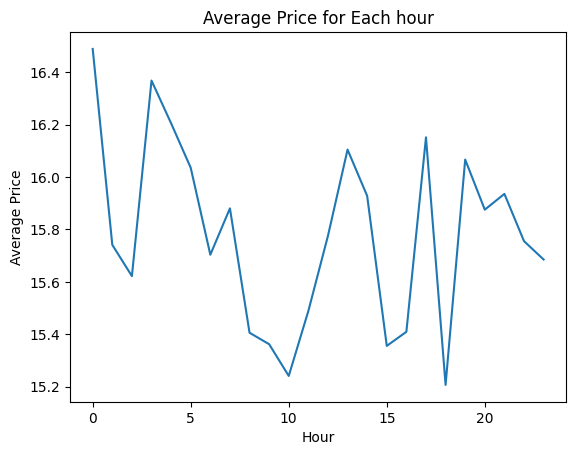

In [ ]:
weekday_prices =  uber_df_final_copy.groupby('weekday')['price'].mean()
plt.plot(weekday_prices.index, weekday_prices.values)
plt.xlabel('Weekday')
plt.ylabel('Average Price')
plt.title('Average Price for Each Weekday')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

hour_prices = uber_df_final_copy.groupby('hour')['price'].mean()
plt.plot(hour_prices.index, hour_prices.values)
plt.xlabel('Hour')
plt.ylabel('Average Price')
plt.title('Average Price for Each hour')
plt.show()

### 2-2. Analyze the distribution of price from each hour

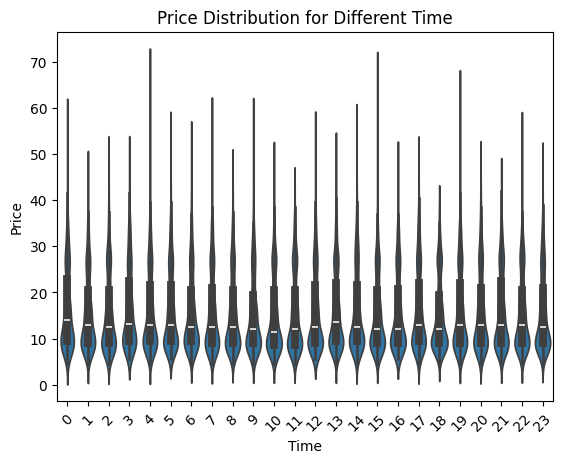

In [ ]:
sns.violinplot(x='hour', y='price', data=uber_df_final_copy)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Distribution for Different Time')
plt.xticks(rotation=45)
plt.show()

### 2-3. Analyze the price from different locations

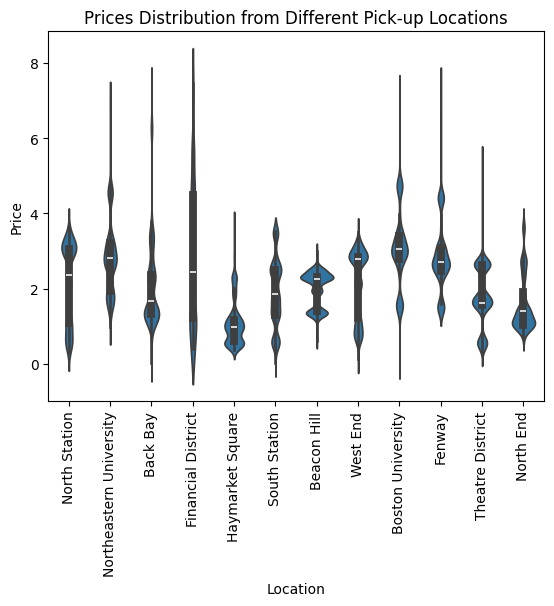

In [ ]:
sns.violinplot(x='source', y='distance', data=uber_df_final)
plt.xlabel('Location')
plt.ylabel('Price')
plt.title('Prices Distribution from Different Pick-up Locations')
plt.xticks(rotation=90)
plt.show()

 # Part 3: Predictive Model #

### 3-1. Ordinary Least Squares(OLS) Regression

In [ ]:
#Create dummy variables
for column, prefix in [('destination', 'des'), ('source', 'src'), ('name', 'type')]:
    if column in uber_df_final_copy.columns:
        df = uber_df_final_copy.copy()
        dummies = pd.get_dummies(df[column], prefix=prefix)
        uber_df_final_copy = pd.concat([uber_df_final_copy, dummies], axis=1)
        uber_df_final_copy = uber_df_final_copy.drop(column, axis=1)

uber_df_final_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27434 entries, 38 to 330567
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype                     
---  ------                       --------------  -----                     
 0   distance                     27434 non-null  float64                   
 1   price                        27434 non-null  float64                   
 2   temp                         27434 non-null  float64                   
 3   clouds                       27434 non-null  float64                   
 4   pressure                     27434 non-null  float64                   
 5   humidity                     27434 non-null  float64                   
 6   wind                         27434 non-null  float64                   
 7   rain_dummy                   27434 non-null  int64                     
 8   date_time_est                27434 non-null  datetime64[ns, US/Eastern]
 9   weekday                      27434 no

In [ ]:
#Using OLS statsmodels
#Define X and y
X = uber_df_final_copy.drop(['price', 'date_time_est'], axis=1)
y = uber_df_final_copy['price']

#Define train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     7255.
Date:                Sat, 16 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:00:12   Log-Likelihood:                -50216.
No. Observations:               21947   AIC:                         1.005e+05
Df Residuals:                   21911   BIC:                         1.008e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

### 3-2. Linear regression model

In [ ]:
#Linear regression
#Define train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train the data
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)

#Model performance
print(reg_all.intercept_, reg_all.coef_)
print('R^2 score of train data is {:.5f}'.format(reg_all.score(X_train, y_train)))
print('R^2 score of test data is {:.5f}'.format(reg_all.score(X_test, y_test)))

#Compute RMSE
rmse_reg = np.sqrt(mean_squared_error(y_test, y_pred))

#Print the RMSE
print('Root Mean Squared Error (RMSE) on test data is {:.5f}'.format(rmse_reg))

#Cross-validation
cv_results_reg = cross_val_score(reg_all, X_train, y_train, cv=5)
print('Cross validation results are', cv_results_reg)
print('The mean of cross validation results is {:.5f}'.format(np.mean(cv_results_reg)))

30786191979.192966 [ 2.47105280e+00  3.85168822e-04  1.47273533e-01  1.77766633e-03
 -1.16518546e-01 -7.73800796e-03  6.24283667e-03 -1.23585407e-02
 -1.16677034e-03  4.52726554e+10  4.52726554e+10  4.37136593e+10
  4.37136593e+10  4.52726554e+10  4.37136593e+10  4.37136593e+10
  4.52726554e+10  4.37136593e+10  4.37136593e+10  4.52726554e+10
  4.52726554e+10 -3.51414068e+10 -3.51414068e+10 -3.67004029e+10
 -3.67004029e+10 -3.51414068e+10 -3.67004029e+10 -3.67004029e+10
 -3.51414068e+10 -3.67004029e+10 -3.67004029e+10 -3.51414068e+10
 -3.51414068e+10 -3.93584445e+10 -3.93584445e+10 -3.93584445e+10
 -3.93584445e+10 -3.93584445e+10 -3.93584445e+10]
R^2 score of train data is 0.92056
R^2 score of test data is 0.91992
Root Mean Squared Error (RMSE) on test data is 2.43565
Cross validation results are [0.92286616 0.91234466 0.92181322 0.92353674 0.92057921]
The mean of cross validation results is 0.92023


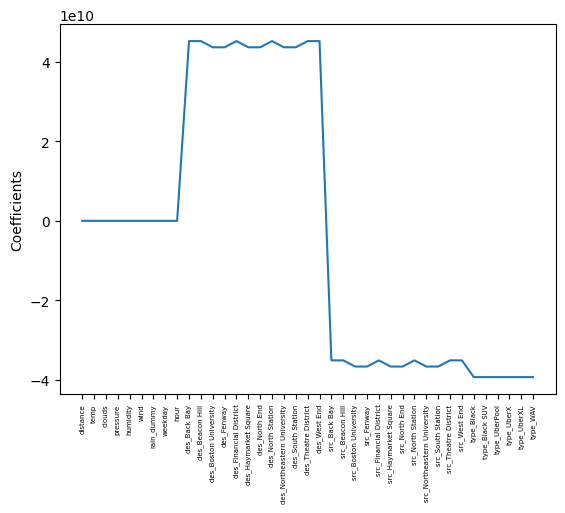

In [ ]:
#Plot linear regression coefficients
names = X.columns

reg_coef = reg_all.coef_
plt.plot(range(len(names)), reg_all.coef_)
plt.xticks(range(len(names)), names, rotation=90, size=5)
plt.ylabel('Coefficients')
plt.show()

### 3-3. Lasso Regression Model

In [ ]:
#Lasso Regression
#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train the data
lasso=Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

#Model performance
print(lasso.intercept_, lasso.coef_)
print('R^2 score of train data is {:.5f}'.format(lasso.score(X_train, y_train)))
print('R^2 score of test data is {:.5f}'.format(lasso.score(X_test, y_test)))

#Compute RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso_pred))

# Print the RMSE
print('Root Mean Squared Error (RMSE) on test data is {:.5f}'.format(rmse_lasso))

#Cross-validation
cv_results_lasso = cross_val_score(lasso, X_train, y_train, cv=5)
print('Cross validation results are', cv_results_lasso)
print('The mean of cross validation results is {:.5f}'.format(np.mean(cv_results_lasso)))

6.5995764235365915 [ 2.31300480e+00  1.81478471e-03  0.00000000e+00  1.01332758e-03
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -3.57815115e-04  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  7.08859632e+00  1.68930381e+01 -3.38527449e+00
 -2.42159496e+00  2.30736418e+00 -2.36256769e+00]
R^2 score of train data is 0.91399
R^2 score of test data is 0.91238
Root Mean Squared Error (RMSE) on test data is 2.54778
Cross validation results are [0.91731047 0.90529148 0.9159198  0.91637836 0.91471577]
The mean of cross validation results is 0.91392


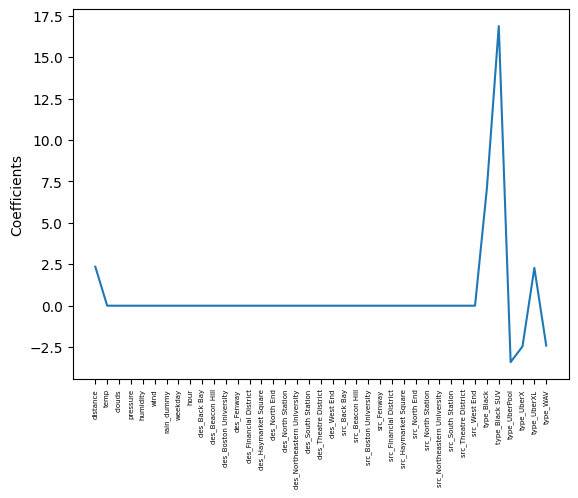

In [ ]:
#Plot lasso regression coefficients
names = X.columns
lasso_coef = lasso.fit(X, y).coef_
plt.plot(range(len(names)), lasso_coef)
plt.xticks(range(len(names)), names, rotation=90, size=5)
plt.ylabel('Coefficients')
plt.show()

 # Part 4: Business Questions #

### 4-1. Identify the factors that influence Uber fares the most

         Variables  Coefficients
0         distance      2.353399
1             temp      0.001033
33      type_Black      7.091656
34  type_Black SUV     16.879220
35   type_UberPool     -3.403956
36      type_UberX     -2.457483
37     type_UberXL      2.284387
38        type_WAV     -2.408602


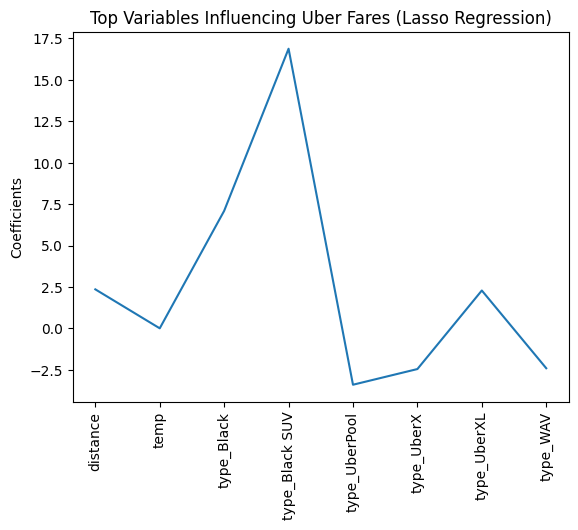

In [ ]:
#Plot variables whose coefficient != 0
lasso_coef_df = pd.DataFrame({'Variables':X.columns, 'Coefficients':lasso_coef})
lasso_coef_df_2 = lasso_coef_df[lasso_coef_df['Coefficients'] != 0]

print(lasso_coef_df_2)

plt.plot(lasso_coef_df_2['Variables'], lasso_coef_df_2['Coefficients'])
plt.xticks(range(len(lasso_coef_df_2['Variables'])), lasso_coef_df_2['Variables'], rotation=90)
plt.ylabel('Coefficients')
plt.title('Top Variables Influencing Uber Fares (Lasso Regression)')
plt.show()

### 4-2. Identify the busiest time frame in a week

   weekday_hour  fre
11         0_19  319
59         2_23  318
24          1_0  297
16         0_23  282
9          0_17  279
10         0_18  279
13         0_20  271
20          0_6  265
15         0_22  252
58         2_22  248
5          0_13  248
54         2_19  247
14         0_21  245
45         2_10  241
53         2_18  241


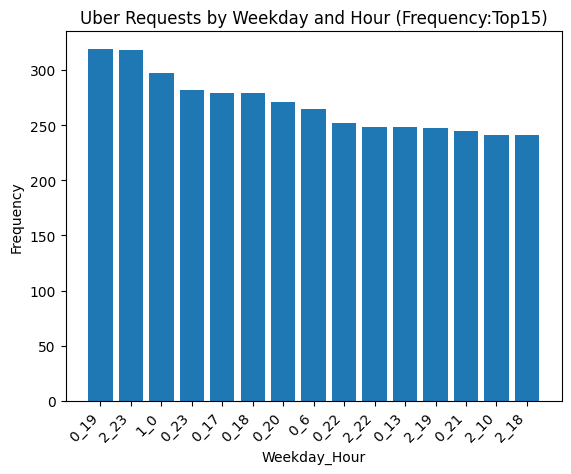

In [ ]:
#Create a new column shows weekday and hour simultaneously
uber_df_final_copy['weekday_hour'] = uber_df_final_copy['weekday'].astype(str) + \
                                    '_' + uber_df_final_copy['hour'].astype(str)

# Group by 'weekday_hour' and count occurrences
frequency_data = uber_df_final_copy.groupby('weekday_hour').size().reset_index(name='fre')
frequency_data = frequency_data.sort_values(by='fre', ascending=False)
frequency_data.head()

# Filter data for values higher than average
high_frequency_data = frequency_data[:15]
print(high_frequency_data)

# Plotting bar chart
plt.bar(high_frequency_data['weekday_hour'], high_frequency_data['fre'])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Weekday_Hour')
plt.ylabel('Frequency')
plt.title('Uber Requests by Weekday and Hour (Frequency:Top15)')
plt.show()

### 4-3. Identify the popular types of Uber for each location

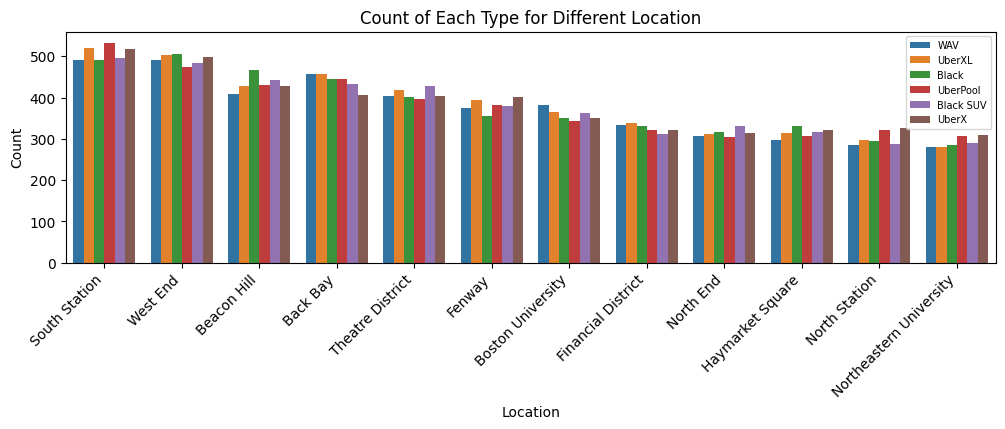

In [ ]:
location_data = uber_df_final.groupby('source')['name'].value_counts().reset_index(name='count')

plt.figure(figsize=(12, 3))
sns.barplot(x='source', y='count', hue='name', data=location_data,
            order=location_data.sort_values(by='count', ascending=False)['source'].unique())
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Count of Each Type for Different Location')
plt.legend(loc='upper right', prop={'size': 7})
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

# Conclusion and the next step #
Conducting Exploratory Data Analysis enables us to uncover nuanced insights, while predictive modeling allows us to discern the key factors influencing Uber fares. Our predictive analysis highlights that distance and ride types exert the most significant influence on Uber fares. While weather data appears to have limited impact, this observation may be attributed to the dataset's constraint to November and December, hindering a comprehensive weather-related analysis. To address this, a comprehensive data collection spanning the entire year is recommended to ascertain the broader influence of weather variables.

Furthermore, despite the dataset encompassing over 20,000 entries, the removal of more than half during the data cleaning process, primarily due to missing 'price' values, underscores the paramount importance of emphasizing data integrity and robustness in our analytical endeavors.

Finally, while our current set of variables provides a foundation, the absence of passenger-side data underscores a crucial gap in our understanding. Integration of passenger information into future models holds the potential to refine market design by tailoring products and strategies to passenger preferences. This strategic incorporation of passenger variables can contribute to the development of more lucrative business strategies and stimulate increased consumption.

# References: #
[1] Kaczmarski, M. (2023, December 11) Uber vs. Lyft: Who’s tops in the battle of U.S. rideshare companies. Bloomberg Second Measure. https://secondmeasure.com/datapoints/rideshare-industry-overview/ \
[2] Uber Fares Dataset https://www.kaggle.com/datasets/yasserh/uber-fares-dataset \
[3] Uber & Lyft Cab Prices https://www.kaggle.com/datasets/ravi72munde/uber-lyft-cab-prices \
[4] About UberPool https://www.uber.com/au/en/drive/services/shared-rides/